## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn.linear_model import LogisticRegression #dont need
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Load data

In [2]:
unprocessed_data = pd.read_csv("../data/raw/train.csv")

In [3]:
unprocessed_data.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Customer Status',
       'Last Due Date', 'Last Payment Date', 'Churn'],
      dtype='object')

In [36]:
np.random.seed(311)
processed_data = unprocessed_data.dropna()
processed_data.loc[processed_data["Support Calls"] == "none"] = 0
X = processed_data[["Age", "Gender", "Tenure", "Usage Frequency", "Support Calls", "Customer Status"]]
y = processed_data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [37]:
X.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Customer Status
3,24,Male,39.0,21,2,active
12,30,Male,54.0,13,3,active
15,0,0,0.0,0,0,0
20,0,0,0.0,0,0,0
22,61,Female,25.0,14,2,active


---------Training performance---------
train_accuracy=0.989727527306993
train_f1_score=0.10623556581986143
---------Testing performance---------
testing_accuracy=0.9891304347826086
testing_f1_score=0.11139240506329114


Text(0.5, 1.0, "Descision Tree (features=['Usage Frequency', 'Age', 'Support Calls'], depth_limit=6)")

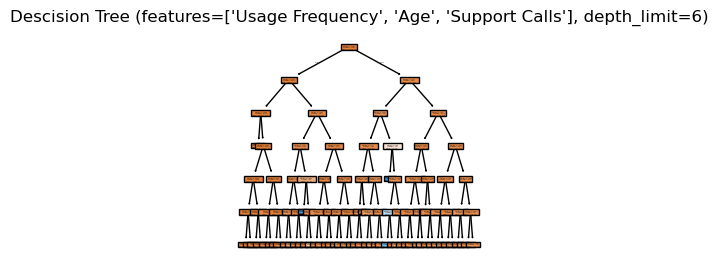

In [38]:
#try ph with depth 1, ph with depth 4, ph with depth None
#try N as the features with the same depth value
#try cycle through the rest of the fa
features = ["Usage Frequency", "Age", "Support Calls"]
depth_limit = 6
model = DecisionTreeClassifier(criterion='entropy', max_depth=depth_limit)
model.fit(X_train[features], y_train)

#Predict on train data
y_pred_train = model.predict(X_train[features])

#Predict on test data
y_pred_test = model.predict(X_test[features])

train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
train_f1_score = metrics.f1_score(y_train, y_pred_train)
testing_accuracy = metrics.accuracy_score(y_test, y_pred_test)
testing_f1_score = metrics.f1_score(y_test, y_pred_test)

print("---------Training performance---------")
print(f"{train_accuracy=}")
print(f"{train_f1_score=}")
print("---------Testing performance---------")
print(f"{testing_accuracy=}")
print(f"{testing_f1_score=}")

plt.figure(figsize=(3,3))
plot_tree(model, feature_names=features, filled=True)
plt.title(f"Descision Tree ({features=}, {depth_limit=})")

## Export

In [73]:
test_data = pd.read_csv("../data/raw/test.csv")
# test_data.loc[test_data["Support Calls"] == "none"]["Support Calls"] = 0
test_data = test_data.replace("none", 0)
test_pred = model.predict(test_data[features])
test_data.value_counts()

CustomerID  Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  Subscription Type  Contract Length  Total Spend  Last Interaction  Last Due Date  Last Payment Date  Customer Status
25          42   Female  29.0    11               2              27             Premium            Monthly          505.00       19.0              06-22          07-19              active             1
336889      47   Female  21.0    23               5              24             Standard           Monthly          722.00       17.0              06-26          07-20              active             1
336899      24   Female  46.0    16               5              10             Basic              Quarterly        194.89       12.0              06-12          06-22              active             1
336909      37   Male    38.0    21               4              15             Standard           Monthly          718.00       2.0               06-07          06-22              active          

In [74]:
export = test_data[["CustomerID"]]
export["Churn"] = test_pred

export.to_csv("../data/processed/export.csv", index=False)

C:\Users\Scott\AppData\Local\Temp\ipykernel_23556\4001471556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export["Churn"] = test_pred
